# Spotify Podcast Dataset

RSS Part2: Parser to read the Podcast Categories from RSS files.

In [146]:
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from collections import Counter
plt.rcParams['figure.figsize'] = [5, 5]


## Parse metadata from Spotify

In [121]:
df = pd.read_csv('../podcasts-no-audio-13GB-selected/metadata.tsv', sep='\t')

In [36]:
basename = '../podcasts-no-audio-13GB-selected/spotify-podcasts-2020/show-rss/'

## Add directory names to the rows

In [127]:
# Locations of episodes are based on two levels of folders: 
#    first_folder/second_folder/show/episode_metadata.json
# To figure out the first_folder and second_folder by looking at 
# the first two characters in the show_uri column.

# Then you can extract the transcripts...

df['first_dir'] = df['show_uri'].str.extract(r'spotify:show:(\w{1})')[0]
df['second_dir'] = df['show_uri'].str.extract(r'spotify:show:\w{1}(\w{1})')[0]

## Extract the RSS category metadata of a show.

In [158]:
print(f"Searching for {df['show_filename_prefix'].unique().shape[0]} Shows.")

Searching for 18376 Shows.


In [151]:
import xml.etree.ElementTree as ET

def find_category(file):
    """
    find_category - attempts to look for the the first itunes:category 
                    tag in the RSS file.  
    returns 
    """    
    extracted_tags = []
    
    # Parse the XML file
    tree = ET.parse(file)
    root = tree.getroot()
    
    # Iterate through the XML elements
    for element in root.iter():
        # Check if the element name contains "category"
        if 'category' in element.tag:
            # Check if the element has a "text" attribute
            if 'text' in element.attrib:
                # Extract and store the data from the "text" attribute
                text_data = element.attrib['text']
                extracted_tags.append(text_data)
    return extracted_tags


Test find_category()...

In [152]:
find_category(basename + '/1/U/' + 'show_1uWrnAjywECBJ6Uz2UEuUV.xml')

['Kids & Family',
 'Parenting',
 'Comedy',
 'Kids & Family',
 'Religion & Spirituality',
 'Religion & Spirituality',
 'Spirituality',
 'Society & Culture',
 'Science',
 'Social Sciences',
 'Society & Culture',
 'Relationships']

In [169]:
files_found_counter = 0

# This list will be appended directly to the primary dataframe 
# directly as a list.  It will follow a similar format as the 
# language column.
#
# The tuple is meant to preserve the filename with the category.
# first element is filename, second element is the category list.
category_tuple_list = []

# This list is an expanded version.  in stead of aggregating 
# the categories with one show.  the show is repeated for each
# category.  Nice for playing around with categories in general.
# But important to remember to understand that merging it with 
# the primary data frame would mean there are now more rows 
# and the rows no longer can be interpreted as the number of 
# episodes for example.
#
# The tuple is meant to preserve the filename with the category.
# first element is filename, second element is the category.
expanded_category_tuple_list = []

error_list = []
notag_list = []
# Iterate through files in the folder and its subdirectories
for root, dirs, files in os.walk(basename):
    for filename in files:
        # Check if the file is a JSON file
        if filename.endswith('.xml'):
            # TODO / ISSUE: there are two more xml files found based on the 
            # metadata file's number of possible shows.
            # TODO / ISSUE: there are 8 errors in valid show RSS files.
            try:
                files_found_counter += 1
                file_path = os.path.join(root, filename)
                cats = find_category(file_path)
                
                # check and see if its empty
                if cats:
                    for cat in cats: 
                        expanded_category_tuple_list.append((filename[:-4], cat))
                    category_tuple_list.append((filename[:-4], cats))
                else:
                    notag_list.append(filename)
            except Exception as e:
                #print(f"Error reading file: {filename}.\n{e}")
                error_list.append(filename)
                
print(f"{files_found_counter} Files Found.")
print(f"{len(set(categories))} Unique Categories and Sub-categories.")
print(f"{len(error_list)} files had errors while reading (see error_list).")
print(f"{len(notag_list)} files had no tags (see notag_list).")

18387 Files Found.
122 Unique Categories and Sub-categories.
10 files had errors while reading (see error_list).
9 files had no tags (see notag_list).


In [170]:
category_tuple_list[:5]

[('show_0RpgmiJjAk5DHxzABcllYp', ['Leisure', 'Games']),
 ('show_0ruY06AVqTtXm1Rs3bwDtZ', ['Society & Culture']),
 ('show_0r4ElWjFWBJRuzH6ooMBvK', ['Sports', 'Basketball']),
 ('show_0R4GSy1q25PM6mttQ3c5Qy', ['Education', 'Language Learning']),
 ('show_0rHf8IEnXNN1w59Uzk4HDF', ['Religion & Spirituality'])]

In [171]:
# notice the repition of the show filename...
expanded_category_tuple_list[:5]

[('show_0RpgmiJjAk5DHxzABcllYp', 'Leisure'),
 ('show_0RpgmiJjAk5DHxzABcllYp', 'Games'),
 ('show_0ruY06AVqTtXm1Rs3bwDtZ', 'Society & Culture'),
 ('show_0r4ElWjFWBJRuzH6ooMBvK', 'Sports'),
 ('show_0r4ElWjFWBJRuzH6ooMBvK', 'Basketball')]

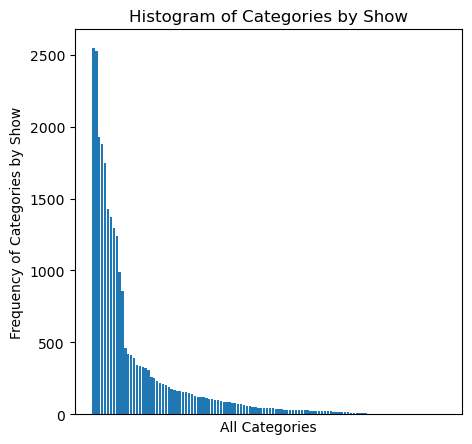

In [174]:
categories_list = [c for s,c in expanded_category_tuple_list] 
category_counts = Counter(categories_list)
sorted_counts = dict(sorted(category_counts.items(), key=lambda item: item[1], reverse=True))
values, frequencies = zip(*sorted_counts.items())
plt.bar(values, frequencies)
# Add labels and title
plt.xlabel('All Categories');
plt.ylabel('Frequency of Categories by Show');
plt.title('Histogram of Categories by Show');
plt.xticks([]);

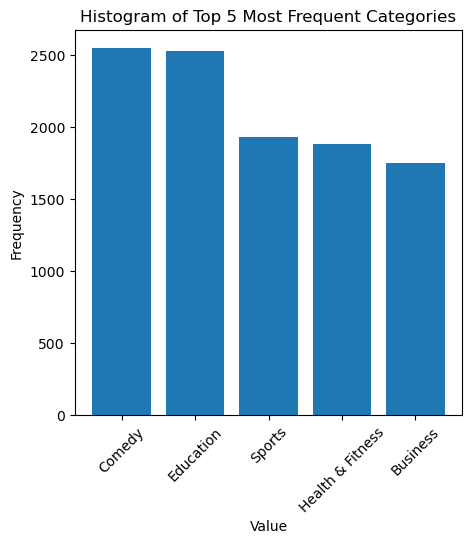

In [175]:
top_5_sorted_counts = dict(sorted(category_counts.items(), key=lambda item: item[1], reverse=True)[:5])
top_5_values, top_5_frequencies = zip(*top_5_sorted_counts.items())
plt.bar(top_5_values, top_5_frequencies)
# Add labels and title
plt.xlabel('Value');
plt.ylabel('Frequency');
plt.title('Histogram of Top 5 Most Frequent Categories');
plt.xticks(rotation=45);

In [95]:
# Create a DataFrame from the list of tuples
cats_df = pd.DataFrame(category_tuple_list, columns=['show_filename_prefix', 'category'])
print(cats_df.shape)
cats_df.head(2)
print(f"NaNs Present: {cats_df['category'].isna().sum()}")


(18372, 2)
NaNs Present: 0


In [91]:
duration_df = df[['show_filename_prefix','duration']].groupby('show_filename_prefix').mean()
duration_df = duration_df.reset_index()
duration_df['mean_show_duration'] = duration_df['duration']
duration_df = duration_df.drop(columns=['duration'])
duration_df.head(2)
print(f"NaNs Present: {duration_df['mean_show_duration'].isna().sum()}")

NaNs Present: 0


In [96]:
cats_df = cats_df.merge(duration_df, on='show_filename_prefix', how='right')
print(cats_df.shape)
print(cats_df.describe())
cats_df.sample(10)
print(f"NaNs Present: {cats_df['mean_show_duration'].isna().sum()}")


(1937, 3)
       mean_show_duration
count         1937.000000
mean            38.022559
std             18.833971
min              0.766026
25%             23.250082
50%             39.056737
75%             52.213392
max             82.411022
NaNs Present: 0


<Axes: ylabel='Frequency'>

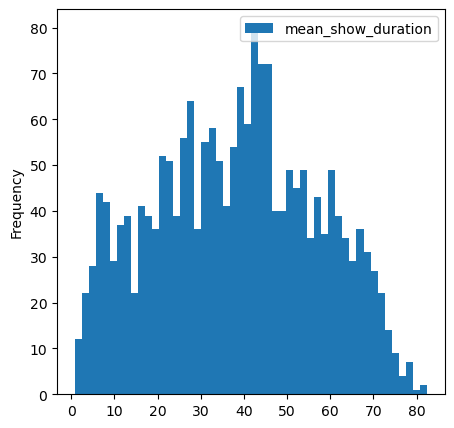

In [93]:
cats_df.plot.hist(y='mean_show_duration',bins=50)

## Attempt to use topics mapped to shows for more insights...

In [97]:
# Create a DataFrame from the list of tuples
cats_df2 = pd.DataFrame(category_tuple_list2, columns=['show_filename_prefix', 'category'])
cats_df2 = cats_df2.merge(duration_df, on='show_filename_prefix', how='right')
print(cats_df2.shape)
cats_df2.head(2)

cats_df2['top_5'] = cats_df2['category'].isin(top_5_values)

print(cats_df2.columns)
print(f"NaNs Present: {cats_df2['mean_show_duration'].isna().sum()}")
new_df = cats_df2[cats_df2['top_5']==True].reset_index().drop(columns=['index']).reset_index()
print(new_df.columns)
print(f"NaNs Present: {new_df['mean_show_duration'].isna().sum()}")

(2866, 3)
Index(['show_filename_prefix', 'category', 'mean_show_duration', 'top_5'], dtype='object')
NaNs Present: 0
Index(['index', 'show_filename_prefix', 'category', 'mean_show_duration',
       'top_5'],
      dtype='object')
NaNs Present: 0


In [99]:
cats_df2_catmean = cats_df2[['category','mean_show_duration']].groupby('category').mean().reset_index()
cats_df2_catmean = cats_df2_catmean.rename(columns={'mean_show_duration': 'mean_category_duration'})
cats_df2_catmean = cats_df2_catmean.sort_values(by='mean_category_duration',ascending=False)
print(f"NaNs Present: {cats_df2_catmean['mean_category_duration'].isna().sum()}")
cats_df2_catmean


NaNs Present: 0


,category,mean_category_duration
28,Film Reviews,72.289888
5,Aviation,69.212562
25,Fantasy Sports,61.913587
6,Baseball,56.238783
98,Wrestling,56.036053
...,...,...
15,Comedy Fiction,19.980779
66,Pets & Animals,19.109841
9,Buddhism,15.957889
88,Stories for Kids,9.985819


In [101]:
cats_df3 = cats_df2.merge(cats_df2_catmean,how='right')
cats_df3 = cats_df3.sort_values(by='mean_category_duration',ascending=False)
cats_df3

,show_filename_prefix,category,mean_show_duration,top_5,mean_category_duration
0,show_3yQgMsqFl1899hFC3UQLaa,Film Reviews,71.855168,False,72.289888
1,show_7ESUQ4DOuo8z3uJGTJcKX6,Film Reviews,72.724608,False,72.289888
2,show_3Lk3ar1iSyFrTwTxLO7TZ4,Aviation,69.212562,False,69.212562
3,show_0FklAMewsMWDPs41hcyGj5,Fantasy Sports,61.397332,False,61.913587
4,show_1H4AwzOR0tkNyFhIl6vz5T,Fantasy Sports,53.039815,False,61.913587
...,...,...,...,...,...
2853,show_50XsjqQQ2tRhyc2DykV76R,Language Learning,0.766026,False,9.822265
2852,show_3oagSxFbg8PZN4gBarH0qD,Language Learning,5.960742,False,9.822265
2850,show_1CMwbrEPRtk46eseEmxFOd,Language Learning,21.272946,False,9.822265
2849,show_0NX1biTiBwY9TsDW6gyeXF,Language Learning,10.724839,False,9.822265


In [ ]:
cats_df4[cats_df4['category']=='Stories for Kids']['mean_show_duration']

Text(0.5, 0, 'All Categories')

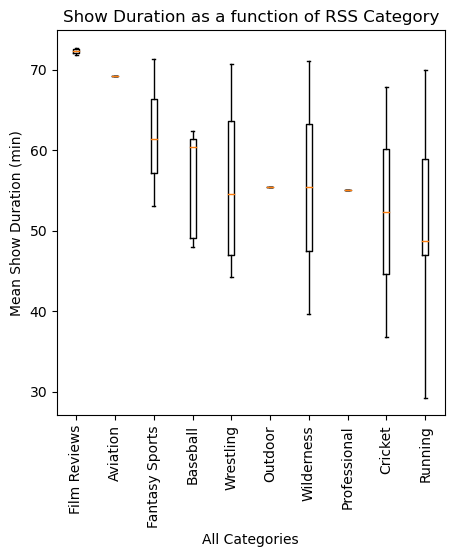

In [107]:
# Define the desired order for the x-axis
categories_my_order = cats_df2_catmean['category'].to_numpy()[:10]

# Create a boxplot and set the order
#cats_df3[['category', 'mean_show_duration']].boxplot(by='category', order=order)
cats_df4 = cats_df3[['category','mean_show_duration']]

#ax = cats_df3[['category','mean_show_duration']].boxplot(by='category')
#ax.set_xticklabels(order, rotation=45);

fig, ax = plt.subplots()
for position, category in enumerate(categories_my_order):
    ax.boxplot(cats_df4[cats_df4['category']==category]['mean_show_duration'], showfliers=False, positions=[position])

#ax.set_xticks(range(position+1))
ax.set_xticklabels(categories_my_order, rotation=90);
#ax.set_xticks([]);
ax.set_title('Show Duration as a function of RSS Category')
ax.set_ylabel('Mean Show Duration (min)')
ax.set_xlabel('All Categories')

In [120]:
cats_df[cats_df['category']=="Cricket"]

,show_filename_prefix,category,mean_show_duration


In [111]:
cats_df2_catmean

,category,mean_category_duration
28,Film Reviews,72.289888
5,Aviation,69.212562
25,Fantasy Sports,61.913587
6,Baseball,56.238783
98,Wrestling,56.036053
...,...,...
15,Comedy Fiction,19.980779
66,Pets & Animals,19.109841
9,Buddhism,15.957889
88,Stories for Kids,9.985819


In [ ]:
new_df[['category','mean_show_duration']].shape

In [ ]:
import altair as alt

# Create a scatter plot with category encoded in color
scatter_plot = alt.Chart(new_df.sample(5000)).mark_circle(size=60).encode(
    x=alt.X('index:O', title='Index'),  # 'O' specifies ordinal encoding
    y=alt.Y('mean_show_duration:Q', title='Duration'),
    color=alt.Color('category:N')
)  # Calculate the index as an ordinal field

scatter_plot = scatter_plot.properties(
    width=400,
    height=300,
    title='Scatter Plot of Duration vs. Category'
).configure_title(
    fontSize=16,
    anchor='middle'
)

scatter_plot

In [ ]:
plt.plot(cats_df['mean_show_duration'],'x')
df.head()

In [ ]:
merged_df = df.merge(cats_df, on='show_filename_prefix', how='left')
print(merged_df.shape)
print(merged_df.columns)
merged_df[merged_df['show_filename_prefix']=='show_4Gtc4ccgCF8xySTleFp3HF']

In [ ]:
# TODO: Why are there 51?  is this the number of episodes in the 
# 8 shows where there were issues finding category?
merged_df['category'].isna().sum()

In [ ]:
merged_df.head()

In [ ]:
# Save the DataFrame as a TSV file
file_path = '../podcasts-no-audio-13GB-selected/metadata_with_podcast_category.tsv'
merged_df.to_csv(file_path, sep='\t', index=False)

print(f"Merged DataFrame saved as {file_path}")

In [ ]:
new_df = pd.read_csv('../podcasts-no-audio-13GB-selected/metadata_with_podcast_category.tsv', sep='\t')
print(new_df.shape)
print(new_df.columns)